# Gradient Boosting Classifier

ToDo's:
- Renaming of variables
- Nice print statements
- Hypertuning for CNN model
- Change multilabel classification (optional)

In [178]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.preprocessing import *
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
import sclblonnx as so
import onnx_graphsurgeon as gs
import tf2onnx
from onnx import *
from onnx import version_converter
from onnx_tf.backend import prepare
import pickle
import sys
import joblib
import os
import keras_tuner as kt

IMAGE_SIZE = [32, 32]

In [42]:
df = pd.read_json('../data/labelled_data/whole_data_1637521796.json', orient='records')

In [43]:
# Show amount of samples
print("amount of samples:", df.shape[0])
df.head(n=3)

amount of samples: 200


,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,Human
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,Human
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,Ambigous heat


## Binary Classification

### Data Preparation

In [44]:
# convert labels to binary
binary_label_converter = { 
    'Human': 1,
    'Several humans': 1, 
    'Non-human heat': 0, 
    'Ambigous heat': 0,
    'No heat':  0,
}


df_binary = df.copy()

df_binary['label'] = df['label'].apply(lambda x: binary_label_converter[x])
df_binary.head(n=3)

,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,1
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,1
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,0


In [45]:
# Prepare the data
y = df_binary['label'].to_numpy()
X = np.array(df_binary['data'].to_list())
X = np.expand_dims(X, axis=3)


print(y.shape)
print(X.shape)

(200,)
(200, 32, 32, 1)


In [46]:
# Create train / val / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(180, 32, 32, 1)
(180,)
(15, 32, 32, 1)
(15,)


### Feature Generation Model

In [47]:
# Simple CNN model

x = tf.keras.layers.Input(shape=[*IMAGE_SIZE,1]) # input is 32x32 pixels RGB
y = tf.keras.layers.Conv2D(kernel_size=3, filters=4, strides=(2,2), padding='same', use_bias=True, activation='relu')(x) # 32x32 -> 16x16
y = tf.keras.layers.Conv2D(kernel_size=3, filters=8, strides=(2,2), padding='same', use_bias=True, activation='relu')(y) # 16x16 -> 8x8
y = tf.keras.layers.Conv2D(kernel_size=3, filters=8, strides=(2,2), padding='same', use_bias=True, activation='relu')(y) # 8x8 -> 4x4
y = tf.keras.layers.Conv2D(kernel_size=3, filters=8, strides=(2,2), padding='same', use_bias=True, activation='relu')(y) # 4x4 -> 2x2
y = tf.keras.layers.Conv2D(kernel_size=3, filters=512, strides=(2,2), padding='same', use_bias=True, activation='relu')(y) # 2x2 -> 1x1
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(64)(y)
y = tf.keras.layers.Dense(32)(y)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.layers.Dense(2, activation='softmax')(y)

model = tf.keras.Model(x, y,name="feature_generator")


model.compile(
optimizer='adam',
loss= 'sparse_categorical_crossentropy',
metrics=['accuracy'])
model.build(input_shape=(None, 32, 32, 1))
model.summary()

Model: "feature_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 4)         40        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 8)           296       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 2, 2, 8)           584       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 1, 512)         37376     
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)         

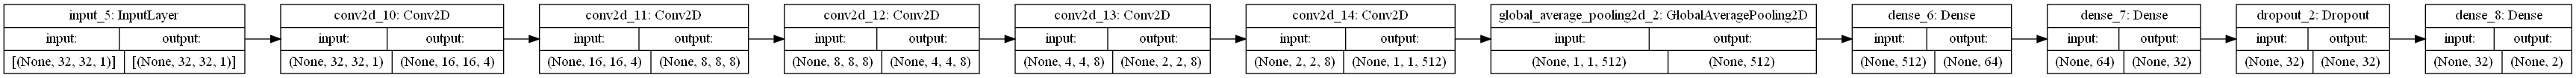

In [48]:
# Plot the model
# `rankdir='LR'` is to make the graph horizontal.
%matplotlib inline
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Epoch 1/20
23/23 [==============================] - 0s 12ms/step - loss: 0.0376 - accuracy: 0.9889 - val_loss: 2.3979 - val_accuracy: 0.7333
Epoch 2/20
23/23 [==============================] - 0s 11ms/step - loss: 0.0179 - accuracy: 0.9944 - val_loss: 2.3760 - val_accuracy: 0.7333
Epoch 3/20
23/23 [==============================] - 0s 10ms/step - loss: 0.0191 - accuracy: 0.9944 - val_loss: 2.7381 - val_accuracy: 0.7333
Epoch 4/20
23/23 [==============================] - 0s 10ms/step - loss: 0.0273 - accuracy: 0.9944 - val_loss: 2.6368 - val_accuracy: 0.7333
Epoch 5/20
23/23 [==============================] - 0s 12ms/step - loss: 0.0537 - accuracy: 0.9889 - val_loss: 2.8724 - val_accuracy: 0.7333
Epoch 6/20
23/23 [==============================] - 0s 10ms/step - loss: 0.0544 - accuracy: 0.9778 - val_loss: 2.4670 - val_accuracy: 0.7333
Epoch 7/20
23/23 [==============================] - 0s 11ms/step - loss: 0.0792 - accuracy: 0.9667 - val_loss: 2.1133 - val_accuracy: 0.7333
Epoch 8/20
23

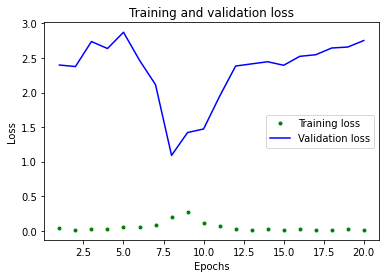

In [117]:
# Fit the model
EPOCHS = 20
BATCH_SIZE = 8
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))


train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training history
plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [118]:
# HP-Tuning on the Feature Generator Model


In [119]:
# Get a list of all convolutional layers from the trained CNN model

def get_conv_layer_list(model):
    
    feature_map_list = []
        
    for i in range(len(model.layers)):
        layer = model.layers[i]
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        
        # Get the layer input and output
        inputs = model.inputs
            
        if i==len(model.layers):
            outputs = model.outputs
        else:
            outputs = model.layers[i].output
        
        current_feature_map = tf.keras.Model(name=layer.name, inputs=inputs, outputs=model.layers[i].output)
        feature_map_list.append(current_feature_map)
    
    return feature_map_list

In [129]:
# Get the last element from the list
feature_extractor_list = get_conv_layer_list(model)
feature_extractor_convs = feature_extractor_list[-1]


# Create a new model with a squeeze layer at the end
feature_extractor = tf.keras.models.Sequential(name="feature_extractor_conv")
feature_extractor.add(feature_extractor_convs)
feature_extractor.add(tf.keras.layers.Reshape([512]))

feature_extractor.build(input_shape=(32, 32, 1))
feature_extractor.summary()

Model: "feature_extractor_conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Functional)       (None, 1, 1, 512)         38880     
_________________________________________________________________
reshape_14 (Reshape)         (None, 512)               0         
Total params: 38,880
Trainable params: 38,880
Non-trainable params: 0
_________________________________________________________________


In [130]:
features = feature_extractor.predict(X)
print(features.shape)

(200, 512)


In [192]:
# Save the model as tf lite model

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(feature_extractor) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('feature_extractor.tflite', 'wb') as f:
  f.write(tflite_model)


# Save the model as onnx model
tf2onnx.convert.from_keras(feature_extractor, output_path="feature_extractor.onnx", opset=6)


# Save as keras model
feature_extractor.save("feature_extractor.h5")

print("Models saved.")

INFO:tensorflow:Assets written to: C:\Users\Felix\AppData\Local\Temp\tmp8p8vpfs9\assets


INFO:tensorflow:Assets written to: C:\Users\Felix\AppData\Local\Temp\tmp8p8vpfs9\assets


Models saved.


### Helpful Functions for Classifiers

In [70]:
# Get the model size in kiB
def get_memory_size(clf, layer_list, fname = "clf_binary"):
    joblib.dump(clf, fname)
    model_size = os.path.getsize(fname)
    model_size = model_size / 1024
    print(f"GBT size in kiB: {model_size}")

    # Get the conv layers size in kiB
    layer_size = 0
    for i in range(len(layer_list)):
        layer_size = os.path.getsize(f"feature_extractor_conv_{i}.h5")
    layer_size = layer_size / 1024
    print(f"Conv layer size in kiB: {layer_size}")

    # Total size for GBT in kiB
    print(f"Total size in kiB: {layer_size + model_size}")

### Prepare Data for Classifier

In [55]:
# df_train_binary_expanded = pd.DataFrame(np.concatenate([df_binary.head(X.shape[0]), feature_extractor.predict(X)], axis=1))
df_train_binary_expanded = pd.DataFrame(np.concatenate([df_binary.head(X.shape[0]), features], axis=1))

In [56]:
df_train_binary_expanded.head(n=2)

,0,1,2,3,4,5,6,7,8,9,...,510,511,512,513,514,515,516,517,518,519
0,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,1,0.0,0.0,...,0.0458,0.0,0.0,0.0,0.009849,0.0,0.0,0.0,0.0,0.0
1,2940,2021-05-07 13:10:22,3078,22.4,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,1,0.0,0.0,...,0.043477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# Prepare the data for gradient boosting
y_clf = df_train_binary_expanded[7].to_numpy().astype(int)
X_clf= df_train_binary_expanded.iloc[:,8:].to_numpy()
print(y_clf.shape)
print(X_clf.shape)

(200,)
(200, 512)


In [68]:
# Create train / val / test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.1, random_state=0)
# X_val_clf, X_test_clf, y_val_clf, y_test_clf = train_test_split(X_test_clf, y_test_clf, test_size=0.3, random_state=0)

print(X_train_clf.shape)
print(y_train_clf.shape)
print(X_test_clf.shape)
print(y_test_clf.shape)
print(y_train_clf[:1])

(180, 512)
(180,)
(20, 512)
(20,)
[0]


### Simple Support Vector Classifier (SVC)

Accuracy Score: 0.65


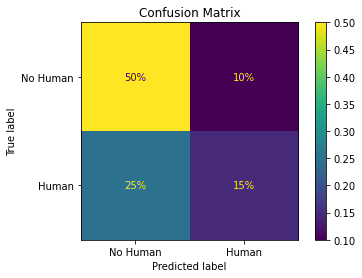

In [69]:
# Train the SVC
svc_clf = SVC()
svc_clf.fit(X_train_clf, y_train_clf)

# Mean accuracy
acc = svc_clf.score(X_test_clf, y_test_clf)
print(f"Accuracy Score: {acc}")

# Calculate and display the confusion matrix
y_pred = svc_clf.predict(X_test_clf)
conf_mat = confusion_matrix(y_test_clf, y_pred, normalize="all")
disp = ConfusionMatrixDisplay(conf_mat, display_labels=["No Human", "Human"])
disp.plot(values_format=".0%")
plt.title("Confusion Matrix")
plt.show()



In [76]:
# Get the memory size of the classifier
get_memory_size(svc_clf, layer_list, fname="simple_svc_clf")

GBT size in kiB: 57.5322265625
Conv layer size in kiB: 177.8203125
Total size in kiB: 235.3525390625


In [190]:
# Convert model to onnx-format and save it
onnx_svc_clf = to_onnx(svc_clf,  X_train_clf.astype(np.float32),
                    options={id(svc_clf): {'zipmap': False}},target_opset=6)
with open("simple_svc_clf.onnx", "wb") as f:
    f.write(onnx_svc_clf.SerializeToString())

### Merge onnx models to one model

In [197]:
model_file_1 = "feature_extractor.onnx"
model_file_2 = "simple_svc_clf.onnx"


onnx_model_1 = load(model_file_1)
onnx_model_1 = version_converter.convert_version(onnx_model_1 , 6)

onnx_model_2 = load(model_file_2)
onnx_model_2 = version_converter.convert_version(onnx_model_2 , 6)

print(onnx_model_1)
print(onnx_model_2)

graph1 = gs.import_onnx(onnx_model_1)
for n in graph1.nodes:
    for cn in n.inputs:
        if cn.name[-1:] != 'a':
            cn.name = f'{cn.name}a'
        else:
            pass
    for cn in n.outputs:
        if cn.name[-1:] != 'a':
            cn.name = f'{cn.name}a'
        else:
            pass
graph1_outputs = [o.name for o in graph1.outputs]
print(f'graph1 outputs: {graph1_outputs}')


graph2 = gs.import_onnx(onnx_model_2)
graph2_inputs = []
for n in graph2.nodes:
    for cn in n.inputs:
        if cn.name[-1:] != 'b':
            cn.name = f'{cn.name}b'
        else:
            pass
    for cn in n.outputs:
        if cn.name[-1:] != 'b':
            cn.name = f'{cn.name}b'
        else:
            pass
graph2_inputs = [i.name for i in graph2.inputs]
print(f'graph2 inputs: {graph2_inputs}')


# Concatenate the two models
merged_model = so.concat(sg1=onnx_model_one.graph, sg2=onnx_model_two.graph)

print(type(merged_model))
so.graph_to_file(merged_model, "merged_model.onnx")



ir_version: 1
producer_name: "tf2onnx"
producer_version: "1.9.3"
graph {
  node {
    input: "conv2d_14_input"
    input: "new_shape__442"
    output: "feature_extractor_conv/conv2d_14/conv2d_10/BiasAdd__406:0"
    name: "feature_extractor_conv/conv2d_14/conv2d_10/BiasAdd__406"
    op_type: "Reshape"
    domain: ""
  }
  node {
    input: "feature_extractor_conv/conv2d_14/conv2d_10/BiasAdd__406:0"
    input: "feature_extractor_conv/conv2d_14/conv2d_10/Conv2D/ReadVariableOp:0"
    input: "feature_extractor_conv/conv2d_14/conv2d_10/BiasAdd/ReadVariableOp:0"
    output: "feature_extractor_conv/conv2d_14/conv2d_10/BiasAdd:0"
    name: "feature_extractor_conv/conv2d_14/conv2d_10/BiasAdd"
    op_type: "Conv"
    attribute {
      name: "dilations"
      ints: 1
      ints: 1
      type: INTS
    }
    attribute {
      name: "strides"
      ints: 2
      ints: 2
      type: INTS
    }
    attribute {
      name: "kernel_shape"
      ints: 3
      ints: 3
      type: INTS
    }
    attribute 

True

### Simple GBT Classifier

Accuracy Score: 0.65


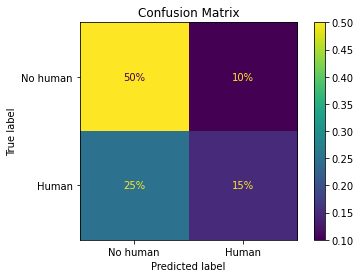

In [59]:
# Train the GBT
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=3, random_state=0).fit(X_train_clf, y_train_clf)

# Mean accuracy
acc = clf.score(X_test_clf, y_test_clf)
print(f"Accuracy Score: {acc}")

# Calculate and display the confusion matrix
y_pred = clf.predict(X_test_clf)
conf_mat = confusion_matrix(y_test_clf, y_pred, normalize="all")
disp = ConfusionMatrixDisplay(conf_mat, display_labels=["No Human", "Human"])
disp.plot(values_format=".0%")
plt.title("Confusion Matrix")
plt.show()

In [71]:
# Get the memory size of the classifier
get_memory_size(clf, layer_list, fname="simple_gbt_clf")

GBT size in kiB: 287.1552734375
Conv layer size in kiB: 177.8203125
Total size in kiB: 464.9755859375


### HP-Tuning for GBT 

In [23]:
# HP-Tuning
MAX_FEATURES = 150

def build_hypermodel(hp):
    
    n_estimators = hp.Int("n_estimators", 10, 100)
    learning_rate = hp.Float("learning_rate", 0.1, 1.0)
    max_depth = hp.Int("max_depth", 1, 4)
    max_features = hp.Int("max_features", 1, MAX_FEATURES)
    
    return GradientBoostingClassifier(n_estimators=n_estimators,
                                      learning_rate=learning_rate, 
                                      max_depth=max_depth,
                                      max_features=max_features,
                                      validation_fraction=0.2,
                                      random_state=0)


In [24]:
MAX_TRIALS = 10

# TODO: Use maybe other metrices!

tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('score', 'max'),
        max_trials=MAX_TRIALS),
    hypermodel=build_hypermodel,
    scoring=skl.metrics.make_scorer(skl.metrics.balanced_accuracy_score),
    metrics=[skl.metrics.accuracy_score, balanced_accuracy_score],
    cv=skl.model_selection.StratifiedKFold(5),
    directory='.',
    project_name='hp_tuning_binary')



tuner.search(X_train_clf, y_train_clf)

best_clf = tuner.get_best_models(num_models=1)[0]

print(f"Best model test score: {best_clf.score(X_test_clf, y_test_clf)}")

print(f"Best model params: {best_clf.get_params()}")

INFO:tensorflow:Reloading Oracle from existing project .\hp_tuning_binary\oracle.json


INFO:tensorflow:Reloading Oracle from existing project .\hp_tuning_binary\oracle.json


INFO:tensorflow:Reloading Tuner from .\hp_tuning_binary\tuner0.json


INFO:tensorflow:Reloading Tuner from .\hp_tuning_binary\tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


ValueError: X has 372 features, but GradientBoostingClassifier is expecting 228 features as input.

In [ ]:
get_memory_size(best_clf, layer_list, fname="best_binary")

In [ ]:
# Compare predictions and ground truth on testing set

y_pred = best_clf.predict(X_test_clf)


print(f"Ground Truth: {y_test_clf}")
print(f"Prediction:   {y_pred}")

# Calculate and display the confusion matrix
conf_mat = confusion_matrix(y_test_clf, y_pred, normalize="all")
disp = ConfusionMatrixDisplay(conf_mat, display_labels=["No human", "Human"])
disp.plot(values_format=".0%")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
# Convert model to onnx-format and save it
initial_type = [('float_input', FloatTensorType([None, 4]))]
onnx = convert_sklearn(best_clf, initial_types=initial_type)
with open("best_clf.onnx", "wb") as f:
    f.write(onnx.SerializeToString())




## Multilabel Classification

In [ ]:
df.head(n=3)

In [ ]:
# Convert labels
label_converter = { 
    'Human': 0,
    'Several humans': 1, 
    'Non-human heat': 2, 
    'Ambigous heat': 3,
    'No heat':  4
}

df['label'] = df['label'].apply(lambda x: label_converter[x])
df.head(n=100)

In [ ]:
# Prepare the data
y = df['label'].to_numpy()
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(max(y)+1))
y_onehot = label_binarizer.transform(y)

X = np.array(df['data'].to_list())
X = np.expand_dims(X, axis=3)
print(y_onehot.shape)
print(y_onehot[:1])
assert np.all(np.sum(y_onehot, axis=1) == 1)
print(X.shape)

In [ ]:
# Create train / val / test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.1, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(y_train[:1])

In [ ]:
# Squeezenet Model

bnmomemtum=0.9

def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
    return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

x = tf.keras.layers.Input(shape=[*IMAGE_SIZE,1]) # input is 32x32 pixels RGB
y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(64)(y)
y = tf.keras.layers.Dense(32)(y)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.layers.Dense(5, activation='softmax')(y)

model = tf.keras.Model(x, y)

In [ ]:
model.compile(
optimizer='adam',
loss= 'categorical_crossentropy',
metrics=['accuracy'])
model.build(input_shape=(None, 32, 32, 5))
model.summary()

In [ ]:
# Fit the model
EPOCHS = 30
BATCH_SIZE = 16
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))


train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training history
plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
layer_list = get_feature_map_list(model)
print(layer_list)

for i in range(len(layer_list)):
    layer_list[i].save(f"layer_{i}")

In [ ]:
# Calculate the feature map mean
feature_map_list = []

im_mean = np.mean(X, axis=(1,2))
im_median = np.median(X, axis=(1,2))
im_std = np.std(X, axis=(1,2))
im_max = np.max(X, axis=(1,2))
im_min = np.min(X, axis=(1,2))
im_sum = np.sum(X, axis=(1,2))

feature_map_list.append(np.concatenate([im_mean,
                                           im_median,
                                           im_std,
                                           im_max,
                                           im_min,
                                           im_sum], axis=1))



# Print the shape of the feature maps
for i in range(len(layer_list)):
    feature_map = layer_list[i].predict(X)
    feature_map_mean = np.mean(feature_map, axis=(1,2))
    feature_map_median = np.median(feature_map, axis=(1,2))
    feature_map_std = np.std(feature_map, axis=(1,2))
    feature_map_max = np.max(feature_map, axis=(1,2))
    feature_map_min = np.min(feature_map, axis=(1,2))
    feature_map_sum = np.sum(feature_map, axis=(1,2))
    feature_map_features = np.concatenate([feature_map_mean,
                                           feature_map_median,
                                           feature_map_std,
                                           feature_map_max, 
                                           feature_map_min, 
                                           feature_map_sum], axis=1)
    feature_map_list.append(feature_map_features)
    
feature_map_means = np.concatenate(feature_map_list, axis=1)
print(feature_map_means.shape)
print(feature_map_means[:1])

In [ ]:
df_train_expanded = pd.DataFrame(np.concatenate([df.head(X.shape[0]), feature_map_means], axis=1))

In [ ]:
# Prepare the data for gradient boosting
y_clf = df_train_expanded[7].to_numpy().astype(int)
X_clf= df_train_expanded.iloc[:,8:].to_numpy()
print(y_clf.shape)
print(X_clf.shape)

In [ ]:
# Create train / val / test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.1, random_state=0)
# X_val_clf, X_test_clf, y_val_clf, y_test_clf = train_test_split(X_test_clf, y_test_clf, test_size=0.3, random_state=0)

print(X_train_clf.shape)
print(y_train_clf.shape)
print(X_test_clf.shape)
print(y_test_clf.shape)
print(y_train_clf[:1])

In [ ]:
# Train the GBT
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=3, random_state=0).fit(X_train_clf, y_train_clf)

# Mean accuracy
clf.score(X_test_clf, y_test_clf)# Train the GBT

In [ ]:
# HP-Tuning
NUM_FEATURES = 198

def build_hypermodel(hp):
    
    n_estimators = hp.Int("n_estimators", 10, 300)
    learning_rate = hp.Float("learning_rate", 0.1, 1.0)
    max_depth = hp.Int("max_depth", 1, 8)
    max_features = hp.Int("max_features", 1, NUM_FEATURES)
    
    return GradientBoostingClassifier(n_estimators=n_estimators,
                                      learning_rate=learning_rate, 
                                      max_depth=max_depth,
                                      max_features=max_features,
                                      validation_fraction=0.2,
                                      random_state=0)

In [ ]:
MAX_TRIALS = 40

# TODO: Use maybe other metrices!

tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('score', 'max'),
        max_trials=MAX_TRIALS),
    hypermodel=build_hypermodel,
    scoring=skl.metrics.make_scorer(skl.metrics.balanced_accuracy_score),
    metrics=[skl.metrics.accuracy_score, balanced_accuracy_score],
    cv=skl.model_selection.StratifiedKFold(5),
    directory='.',
    project_name='hp_tuning')



tuner.search(X_train_clf, y_train_clf)

best_model = tuner.get_best_models(num_models=1)[0]

print(f"Best model test score: {best_model.score(X_test_clf, y_test_clf)}")

print(f"Best model params: {best_model.get_params()}")

In [ ]:
get_memory_size(best_model, layer_list, fname="best")

In [ ]:
# Compare predictions and ground truth
pred = best_model.predict(X_test_clf)

print(f"Ground Truth: {y_test_clf}")
print(f"Prediction:   {pred}")